# E-Discovery with Neural Network
## BigData Processing
### Hadoop / PySpark 

In [1]:
# Commands to be include in the Linux Terminal in order to start Hadoop and PySpark

#start-dfs.sh
#start-yarn.sh
#pyspark

### PySpark reading a file form a CSV

In [2]:
# Initiating required modules
from pyspark.sql import SparkSession  # Essential for Spark operations
from pyspark.sql.functions import udf  # User Defined Functions
from pyspark.sql.types import StringType  # Data type for string operations
import re  # Regular expressions library

# Handling warnings
import warnings  # Importing warnings library
warnings.filterwarnings("ignore")  # Suppress all warnings


In [3]:
# Setting up the Spark Session
spark = SparkSession.builder.appName("EmailDataPrep").getOrCreate()

# Reading the data
df = spark.read.csv("hdfs:///user1/emails.csv", header=True, inferSchema=True)


24/03/29 12:27:12 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### Exploratory Data Analysis (EDA) / Data Inspection

In [4]:
# Preview the initial rows of the DataFrame
df.show(n=10)


+--------------------+--------------------+
|                file|             message|
+--------------------+--------------------+
|allen-p/_sent_mai...|Message-ID: <1878...|
|           Date: Mon| 14 May 2001 16:3...|
|From: phillip.all...|                null|
|To: tim.belden@en...|                null|
|           Subject: |                null|
|   Mime-Version: 1.0|                null|
|Content-Type: tex...|                null|
|Content-Transfer-...|                null|
|X-From: Phillip K...|                null|
|X-To: Tim Belden ...|                null|
+--------------------+--------------------+
only showing top 10 rows



In [5]:
# Output the structure and data types of the DataFrame
df.printSchema()


root
 |-- file: string (nullable = true)
 |-- message: string (nullable = true)



In [6]:
# Obtain and display descriptive statistics for columns with numerical data
df.describe().show()


+-------+--------------------+--------+
|summary|                file| message|
+-------+--------------------+--------+
|  count|             8299853| 2508249|
|   mean|                 NaN|Infinity|
| stddev|                 NaN|     NaN|
|    min|                  \t|      \t|
|    max|~~~~~~~~~~~~~~~~~...|       ||
+-------+--------------------+--------+



### Data Cleaning / Text Preprocessing

In [7]:
# Addressing Missing Information
# Replace any missing values in the dataset with an empty string.
df = df.fillna('')

# Defining a Function for Text Cleanup
def clean_text(text):
    # Return an empty string if the input text is missing.
    if text is None:
        return ''
    # Change all characters in the text to lowercase for uniformity.
    text = text.lower()
    # Eliminate lines that resemble email headers or unneeded metadata.
    text = re.sub(r'^[a-z]+:.*$', '', text)  # Finds and removes lines starting with certain patterns.
    text = re.sub(r'\s+', ' ', text)  # Collapses multiple spaces into a single space.
    # Remove characters that are not letters, numbers, or spaces.
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Trim leading or trailing spaces from the text.
    return text.strip()

# Making the Text Cleanup Function Available
clean_text_udf = udf(clean_text, StringType())

# Cleaning Text in the 'message' Column of the Dataset
df = df.withColumn('message', clean_text_udf(df['message']))

# Displaying the Processed Data for Review
df.show(truncate=False)


+----------------------------------------------+-------------------------------------------------+
|file                                          |message                                          |
+----------------------------------------------+-------------------------------------------------+
|allen-p/_sent_mail/1.                         |messageid 187829811075855378110javamailevansthyme|
|Date: Mon                                     |14 may 2001 163900 0700 pdt                      |
|From: phillip.allen@enron.com                 |                                                 |
|To: tim.belden@enron.com                      |                                                 |
|Subject:                                      |                                                 |
|Mime-Version: 1.0                             |                                                 |
|Content-Type: text/plain; charset=us-ascii    |                                                 |
|Content-T

### Feature Engineering and Vectorization

In [8]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline

def add_text_features(dataframe):
    """
    Enhances a DataFrame by analyzing text in the 'message' column and adding a 'features' column.
    This 'features' column represents text as numerical data useful for machine learning.
    
    Parameter:
    - dataframe: A DataFrame that includes a 'message' column with text.
    
    Output:
    - A DataFrame that now includes a 'features' column with text analyzed into TF-IDF vectors.
    """
    # First, break text into individual words.
    tokenizer = Tokenizer(inputCol="message", outputCol="words")
    
    # Second, filter out common, less meaningful words (like 'the', 'a').
    remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    
    # Third, count how frequently each word appears and represent this as numerical data.
    hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=20)
    
    # Fourth, assess the importance of a word based on how frequently it appears across all messages.
    idf = IDF(inputCol="raw_features", outputCol="features")
    
    # Chain these steps into a process to be applied.
    pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])
    
    # Execute the process on the provided data.
    model = pipeline.fit(dataframe)
    
    # Apply the transformations to the DataFrame.
    result = model.transform(dataframe)
    
    # The modified DataFrame is returned, now with a 'features' column.
    return result

# Example of applying this function to a DataFrame 'df' that contains a 'message' column.
enhanced_df = add_text_features(df)

# Display the original messages and their corresponding numerical representations.
enhanced_df.select('message', 'features').show(truncate=False)


+-------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+
|message                                          |features                                                                                                         |
+-------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+
|messageid 187829811075855378110javamailevansthyme|(20,[12,14],[0.2628853782003786,3.435649098139253])                                                              |
|14 may 2001 163900 0700 pdt                      |(20,[0,1,5,12],[6.620332160461084,6.1845443249149366,3.2725815853775964,0.2628853782003786])                     |
|                                                 |(20,[12],[0.2628853782003786])                                                                                   |
|   

### Designing the Neural Network

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

# Set the number of input features, matching the TF-IDF vector size, which is 20 in this case.
input_dim = 20  # Matches TF-IDF vector size.

# Create a neural network model.
model = Sequential()
# Add a dense layer with 64 neurons, using ReLU activation function, suitable for the input layer.
model.add(Dense(64, input_dim=input_dim, activation='relu'))  # Adds first hidden layer.
# Include a dropout layer to reduce overfitting by randomly ignoring some neurons during training.
model.add(Dropout(0.5))  # Helps in preventing overfitting.
# Add another dense layer, this time with 32 neurons, also with ReLU activation function.
model.add(Dense(32, activation='relu'))  # Adds second hidden layer.
# Finalize with an output layer having a single neuron, using sigmoid activation function for binary classification.
model.add(Dense(1, activation='sigmoid'))  # Adds output layer for binary classification.

# Setting up the model with binary crossentropy loss function, Adam optimizer for efficient learning, and tracking accuracy.
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Display a summary to review the model's architecture, including layer types and number of parameters.
model.summary()


2024-03-29 12:28:44.388518: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-29 12:28:44.815886: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 12:28:44.816007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 12:28:44.896277: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-29 12:28:45.061723: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-29 12:28:45.066424: I tensorflow/core/platform/cpu_feature_guard.cc:1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1344      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3457 (13.50 KB)
Trainable params: 3457 (13.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Design and Training - ANN Model

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential, save_model
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

def build_neural_network(input_features):
    """
    Prepares a neural network model with a basic configuration.
    """
    model = Sequential([
        Dense(64, input_dim=input_features, activation='relu'),  # Layer with 64 neurons
        Dropout(0.5),  # Helps reduce overfitting
        Dense(32, activation='relu'),  # Another layer for deeper understanding
        Dense(1, activation='sigmoid')  # Final layer for binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(features, labels, input_feature_count, epochs=100, batch_size=32, validation_split=0.2):
    """
    Trains the neural network and evaluates it on a validation set.
    """
    # Splitting the dataset for training and validation
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=validation_split, random_state=42)
    
    # Getting the model ready
    model = build_neural_network(input_feature_count)
    
    # Training starts
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), verbose=1)
    
    print("Training Completed.")
    
    # Saving the model for later use
    model.save("model_saved.h5")
    print("Model saved as model_saved.h5.")
    
    return model, history

# Sample data for testing
demo_features = np.random.rand(1000, 20)  # Random features for 1000 samples
demo_labels = np.random.randint(2, size=(1000, ))  # Random binary labels

# Training the model with the demo data
input_features = 20
model, history = train_and_evaluate_model(demo_features, demo_labels, input_features)



Epoch 1/100
25/25 [==============================] - 1s 10ms/step - loss: 0.6925 - accuracy: 0.5312 - val_loss: 0.7055 - val_accuracy: 0.4800
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6885 - accuracy: 0.5350 - val_loss: 0.7050 - val_accuracy: 0.4650
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6868 - accuracy: 0.5550 - val_loss: 0.7005 - val_accuracy: 0.4850
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6859 - accuracy: 0.5400 - val_loss: 0.7037 - val_accuracy: 0.4850
Epoch 5/100
25/25 [==============================] - 0s 6ms/step - loss: 0.6865 - accuracy: 0.5362 - val_loss: 0.7062 - val_accuracy: 0.4850
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6846 - accuracy: 0.5562 - val_loss: 0.7010 - val_accuracy: 0.4750
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 0.6801 - accuracy: 0.5825 - val_loss: 0.7053 - val_accuracy: 0.4850
Epoch 8/100


Epoch 59/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6117 - accuracy: 0.6637 - val_loss: 0.7750 - val_accuracy: 0.4750
Epoch 60/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6017 - accuracy: 0.6825 - val_loss: 0.7570 - val_accuracy: 0.4750
Epoch 61/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6091 - accuracy: 0.6750 - val_loss: 0.7761 - val_accuracy: 0.4750
Epoch 62/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6037 - accuracy: 0.6750 - val_loss: 0.7632 - val_accuracy: 0.4650
Epoch 63/100
25/25 [==============================] - 0s 5ms/step - loss: 0.5971 - accuracy: 0.6712 - val_loss: 0.7630 - val_accuracy: 0.4550
Epoch 64/100
25/25 [==============================] - 0s 5ms/step - loss: 0.5955 - accuracy: 0.6837 - val_loss: 0.7743 - val_accuracy: 0.4500
Epoch 65/100
25/25 [==============================] - 0s 5ms/step - loss: 0.5968 - accuracy: 0.6750 - val_loss: 0.7627 - val_accuracy: 0.4950
Epoch 

In [11]:
from keras.models import load_model
import numpy as np

def get_fraud_chance(model_file, data):
    """
    This function takes a path to a trained machine learning model and an array of data,
    and it returns the model's estimates of the likelihood that each data point is fraudulent.
    
    Arguments:
    - model_file: The location of the trained model on the disk.
    - data: Array of data points that the model will evaluate. This array should be formatted just like the data used to train the model.
    
    Outcome:
    - An array with each data point's estimated fraud likelihood according to the model.
    """
    # Opening the model from the given file
    trained_model = load_model(model_file)
    
    # Making predictions with the model on the provided data
    fraud_chances = trained_model.predict(data)
    
    return fraud_chances

# Example: Predicting with a hypothetical model
# Setting up variables for demonstration. The real values depend on your specific model and data.
sample_count = 100  # Suppose you have 100 pieces of data
expected_shape = (20,)  # Suppose each piece of data should have 20 features

# Creating random data for the demonstration. In real use, you'd have actual data here.
data_samples = np.random.rand(sample_count, *expected_shape)

# Calling the function with the model's file path and the sample data
predicted_fraud_chances = get_fraud_chance('model_saved.h5', data_samples)

# Showing the model's fraud likelihood estimates for the sample data
print(predicted_fraud_chances)


4/4 [==============================] - 0s 2ms/step
[[0.57746357]
 [0.412652  ]
 [0.6455055 ]
 [0.7895856 ]
 [0.62596804]
 [0.737918  ]
 [0.45186386]
 [0.69777185]
 [0.38276827]
 [0.01963443]
 [0.27400553]
 [0.54754454]
 [0.540306  ]
 [0.5945976 ]
 [0.5668119 ]
 [0.08793189]
 [0.74001807]
 [0.20215851]
 [0.6662454 ]
 [0.23531897]
 [0.54533744]
 [0.56673336]
 [0.40893   ]
 [0.48914406]
 [0.18496193]
 [0.8353027 ]
 [0.63765115]
 [0.33003566]
 [0.637774  ]
 [0.7354469 ]
 [0.2932532 ]
 [0.40059555]
 [0.31094095]
 [0.44331044]
 [0.10287195]
 [0.067145  ]
 [0.5038582 ]
 [0.9307418 ]
 [0.49650958]
 [0.35115   ]
 [0.5887735 ]
 [0.6452477 ]
 [0.5186871 ]
 [0.625717  ]
 [0.5560086 ]
 [0.26759094]
 [0.6559692 ]
 [0.49654964]
 [0.5478738 ]
 [0.79956007]
 [0.54563564]
 [0.20515735]
 [0.5221365 ]
 [0.39609167]
 [0.46448767]
 [0.48168874]
 [0.08290228]
 [0.5762984 ]
 [0.24767004]
 [0.51173425]
 [0.15767838]
 [0.5940373 ]
 [0.3626845 ]
 [0.3972056 ]
 [0.2425192 ]
 [0.47410515]
 [0.6160384 ]
 [0.9250765

4/4 [==============================] - 0s 2ms/step


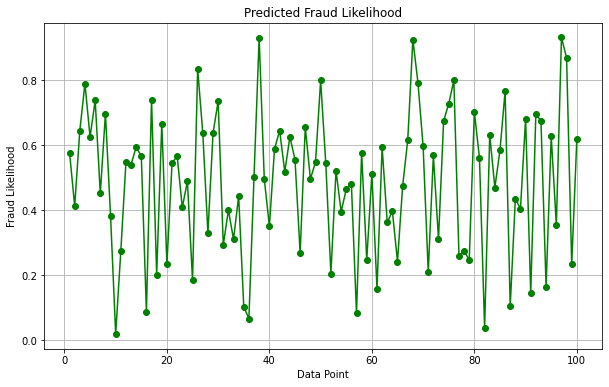

In [12]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

def get_fraud_chance_with_visualization(model_file, data):
    """
    This function takes a path to a trained machine learning model and an array of data,
    and it returns the model's estimates of the likelihood that each data point is fraudulent.
    It also visualizes these estimates.
    
    Arguments:
    - model_file: The location of the trained model on the disk.
    - data: Array of data points that the model will evaluate. This array should be formatted just like the data used to train the model.
    
    Outcome:
    - A visualization of each data point's estimated fraud likelihood according to the model.
    - An array with each data point's estimated fraud likelihood according to the model.
    """
    # Opening the model from the given file
    trained_model = load_model(model_file)
    
    # Making predictions with the model on the provided data
    fraud_chances = trained_model.predict(data).flatten()  # Ensuring it's a 1D array for easy plotting
    
    # Visualizing the fraud chances
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, len(fraud_chances) + 1), fraud_chances, marker='o', linestyle='-', color='green')
    plt.title('Predicted Fraud Likelihood')
    plt.xlabel('Data Point')
    plt.ylabel('Fraud Likelihood')
    plt.grid(True)
    plt.show()
    
    return fraud_chances

# Example usage:
# Assuming data_samples is defined as your input data array
predicted_fraud_chances = get_fraud_chance_with_visualization('model_saved.h5', data_samples)

# Note: You would replace 'model_saved.h5' with the actual path to your ANN model file,
# and ensure `data_samples` is prepared correctly for your model.


### Design and Training - CNN Model

In [13]:
from keras.models import Sequential, save_model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np

def configure_cnn_model(input_length, num_features):
    """Configures a basic one-dimensional Convolutional Neural Network (CNN)."""
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(input_length, num_features)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def prepare_and_train_model(input_length=12, num_features=20, epochs=100, batch_size=32, test_split=0.2, sample_size=100):
    """
    Generates synthetic data and uses it to train the CNN model.
    This method streamlines the process of dataset creation and model training.
    """
    # Generating synthetic data
    features = np.random.rand(sample_size, input_length, num_features)
    labels = np.random.randint(2, size=(sample_size,))

    # Splitting the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=test_split, random_state=42)
    
    # Setting up the CNN model
    model = configure_cnn_model(input_length, num_features)
    
    # Training the model with the synthetic data
    training_summary = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1)
    
    # Displaying training and validation results
    print(f"Final Training Loss: {training_summary.history['loss'][-1]:.4f}")
    print(f"Final Training Accuracy: {training_summary.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Loss: {training_summary.history['val_loss'][-1]:.4f}")
    print(f"Final Validation Accuracy: {training_summary.history['val_accuracy'][-1]:.4f}")
    
    # Saving the trained model to a file
    model.save('cnn_model.h5')
    print("Model training complete and saved as cnn_model.h5.")

# Running the training process with predefined settings
prepare_and_train_model()


Epoch 1/100
3/3 [==============================] - 1s 78ms/step - loss: 0.7278 - accuracy: 0.5750 - val_loss: 0.7207 - val_accuracy: 0.5500
Epoch 2/100
3/3 [==============================] - 0s 18ms/step - loss: 0.6713 - accuracy: 0.6000 - val_loss: 0.7024 - val_accuracy: 0.5500
Epoch 3/100
3/3 [==============================] - 0s 25ms/step - loss: 0.7213 - accuracy: 0.5250 - val_loss: 0.7038 - val_accuracy: 0.5000
Epoch 4/100
3/3 [==============================] - 0s 23ms/step - loss: 0.6311 - accuracy: 0.6750 - val_loss: 0.7096 - val_accuracy: 0.4500
Epoch 5/100
3/3 [==============================] - 0s 27ms/step - loss: 0.6973 - accuracy: 0.5250 - val_loss: 0.7205 - val_accuracy: 0.5000
Epoch 6/100
3/3 [==============================] - 0s 22ms/step - loss: 0.6378 - accuracy: 0.6375 - val_loss: 0.7399 - val_accuracy: 0.4500
Epoch 7/100
3/3 [==============================] - 0s 31ms/step - loss: 0.6805 - accuracy: 0.6375 - val_loss: 0.7437 - val_accuracy: 0.4500
Epoch 8/100
3/3 [===

3/3 [==============================] - 0s 22ms/step - loss: 0.1597 - accuracy: 0.9750 - val_loss: 0.9336 - val_accuracy: 0.4500
Epoch 60/100
3/3 [==============================] - 0s 21ms/step - loss: 0.1604 - accuracy: 0.9625 - val_loss: 0.9058 - val_accuracy: 0.4500
Epoch 61/100
3/3 [==============================] - 0s 22ms/step - loss: 0.1480 - accuracy: 0.9875 - val_loss: 0.9111 - val_accuracy: 0.4500
Epoch 62/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1274 - accuracy: 1.0000 - val_loss: 0.9260 - val_accuracy: 0.4000
Epoch 63/100
3/3 [==============================] - 0s 21ms/step - loss: 0.1213 - accuracy: 1.0000 - val_loss: 0.9376 - val_accuracy: 0.4000
Epoch 64/100
3/3 [==============================] - 0s 21ms/step - loss: 0.1192 - accuracy: 1.0000 - val_loss: 0.9586 - val_accuracy: 0.4000
Epoch 65/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0957 - accuracy: 1.0000 - val_loss: 0.9880 - val_accuracy: 0.4000
Epoch 66/100
3/3 [========

In [14]:
from keras.models import load_model
import numpy as np
import pandas as pd

def evaluate_fraud_risk(model_file, input_data):
    """
    This function opens a machine learning model that's been trained to identify fraud.
    It examines each data point provided to estimate its likelihood of being fraudulent.
    The results are organized into a table, making it easier to understand the model's assessments.
    
    Arguments:
    - model_file: The file location of the machine learning model.
    - input_data: Data for the model to evaluate, formatted as an array. This array must be prepared in the same way as the data used for training the model.
    
    Outcome:
    - A table (DataFrame) showing each data point with its calculated fraud risk.
    """
    # Opening the specified machine learning model
    trained_model = load_model(model_file)
    
    # Using the model to estimate fraud risk for the provided data
    estimated_risk = trained_model.predict(input_data).flatten()
    
    # Organizing the risk estimates into a table
    risk_table = pd.DataFrame({
        'Data Point': np.arange(1, len(estimated_risk) + 1), 
        'Estimated Fraud Risk': estimated_risk
    })
    
    # Sharing the organized table
    return risk_table

# For the purpose of demonstration, synthetic data resembling the model's training format is created
sample_size = 100  # Suppose there are 100 data points to evaluate
sequence_length = 12  # Each data point is a sequence of 12 steps
feature_count = 20  # Each step in the sequence has 20 features
simulated_data = np.random.rand(sample_size, sequence_length, feature_count)

# Predicting fraud risk with the provided model file and simulated data
fraud_risk_table = evaluate_fraud_risk('cnn_model.h5', simulated_data)
# Showing the first 40 data points and their estimated fraud risk for clarity
print(fraud_risk_table.tail(60))


4/4 [==============================] - 0s 4ms/step
    Data Point  Estimated Fraud Risk
40          41              0.991229
41          42              0.958037
42          43              0.098791
43          44              0.637897
44          45              0.310371
45          46              0.970928
46          47              0.713758
47          48              0.961419
48          49              0.189325
49          50              0.135144
50          51              0.510570
51          52              0.972552
52          53              0.801541
53          54              0.499897
54          55              0.033091
55          56              0.919522
56          57              0.453977
57          58              0.500367
58          59              0.610066
59          60              0.213018
60          61              0.024976
61          62              0.879370
62          63              0.268285
63          64              0.317167
64          65          

4/4 [==============================] - 0s 2ms/step


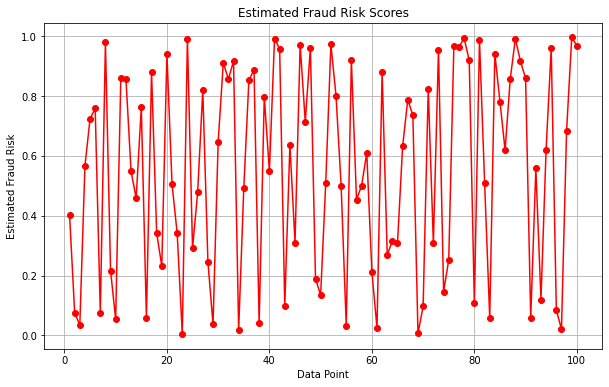

In [15]:
from keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_fraud_risk_with_visualization(model_file, input_data):
    """
    This function opens a machine learning model that's been trained to identify fraud.
    It examines each data point provided to estimate its likelihood of being fraudulent.
    The results are organized into a table and visualized, making it easier to understand the model's assessments.
    
    Arguments:
    - model_file: The file location of the machine learning model.
    - input_data: Data for the model to evaluate, formatted as an array. This array must be prepared in the same way as the data used for training the model.
    
    Outcome:
    - A table (DataFrame) showing each data point with its calculated fraud risk.
    - A visualization of the estimated fraud risk scores.
    """
    # Opening the specified machine learning model
    trained_model = load_model(model_file)
    
    # Using the model to estimate fraud risk for the provided data
    estimated_risk = trained_model.predict(input_data).flatten()
    
    # Organizing the risk estimates into a table
    risk_table = pd.DataFrame({
        'Data Point': np.arange(1, len(estimated_risk) + 1), 
        'Estimated Fraud Risk': estimated_risk
    })
    
    # Visualizing the risk scores
    plt.figure(figsize=(10, 6))
    plt.plot(risk_table['Data Point'].values, risk_table['Estimated Fraud Risk'].values, marker='o', linestyle='-', color='red')
    plt.title('Estimated Fraud Risk Scores')
    plt.xlabel('Data Point')
    plt.ylabel('Estimated Fraud Risk')
    plt.grid(True)
    plt.show()
    
    # Sharing the organized table
    return risk_table

# For the purpose of demonstration, synthetic data resembling the model's training format is created
# sample_size = 100  # Suppose there are 100 data points to evaluate
# sequence_length = 12  # Each data point is a sequence of 12 steps
# feature_count = 20  # Each step in the sequence has 20 features
# simulated_data = np.random.rand(sample_size, sequence_length, feature_count)

# Predicting fraud risk with the provided model file and simulated data
fraud_risk_table_with_viz = evaluate_fraud_risk_with_visualization('cnn_model.h5', simulated_data)
# Note: You would replace 'cnn_model.h5' with the actual path to your CNN model file,
# and ensure `simulated_data` is prepared correctly for your model.


### Design and Training - RNN Model

In [16]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np


In [17]:
def configure_rnn_model(input_length, num_features):
    """Configures a basic Recurrent Neural Network (RNN) using LSTM layers."""
    model = Sequential([
        LSTM(32, return_sequences=True, input_shape=(input_length, num_features)),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [18]:
def prepare_and_train_rnn_model(input_length=12, num_features=20, epochs=100, batch_size=32, test_split=0.2, sample_size=100):
    """
    Generates synthetic data and uses it to train the RNN model.
    """
    # Generating synthetic data
    features = np.random.rand(sample_size, input_length, num_features)
    labels = np.random.randint(2, size=(sample_size,))

    # Splitting the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=test_split, random_state=42)
    
    # Setting up the RNN model
    model = configure_rnn_model(input_length, num_features)
    
    # Training the model with the synthetic data
    training_summary = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1)
    
    # Displaying training and validation results
    print(f"Final Training Loss: {training_summary.history['loss'][-1]:.4f}")
    print(f"Final Training Accuracy: {training_summary.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Loss: {training_summary.history['val_loss'][-1]:.4f}")
    print(f"Final Validation Accuracy: {training_summary.history['val_accuracy'][-1]:.4f}")
    
    # Saving the trained model to a file
    model.save('rnn_model.h5')
    print("Model training complete and saved as rnn_model.h5.")

# You can now run the training process with:
prepare_and_train_rnn_model()


Epoch 1/100
3/3 [==============================] - 3s 266ms/step - loss: 0.6915 - accuracy: 0.5625 - val_loss: 0.6984 - val_accuracy: 0.1500
Epoch 2/100
3/3 [==============================] - 0s 36ms/step - loss: 0.7077 - accuracy: 0.4625 - val_loss: 0.6897 - val_accuracy: 0.6500
Epoch 3/100
3/3 [==============================] - 0s 37ms/step - loss: 0.7023 - accuracy: 0.4875 - val_loss: 0.6925 - val_accuracy: 0.6500
Epoch 4/100
3/3 [==============================] - 0s 36ms/step - loss: 0.6987 - accuracy: 0.4750 - val_loss: 0.6928 - val_accuracy: 0.6000
Epoch 5/100
3/3 [==============================] - 0s 39ms/step - loss: 0.7036 - accuracy: 0.4125 - val_loss: 0.6818 - val_accuracy: 0.7000
Epoch 6/100
3/3 [==============================] - 0s 37ms/step - loss: 0.6918 - accuracy: 0.5500 - val_loss: 0.6766 - val_accuracy: 0.7000
Epoch 7/100
3/3 [==============================] - 0s 45ms/step - loss: 0.7003 - accuracy: 0.4625 - val_loss: 0.6726 - val_accuracy: 0.7000
Epoch 8/100
3/3 [==

3/3 [==============================] - 0s 37ms/step - loss: 0.5563 - accuracy: 0.7125 - val_loss: 0.8030 - val_accuracy: 0.5000
Epoch 60/100
3/3 [==============================] - 0s 36ms/step - loss: 0.5166 - accuracy: 0.7500 - val_loss: 0.7755 - val_accuracy: 0.5500
Epoch 61/100
3/3 [==============================] - 0s 37ms/step - loss: 0.5453 - accuracy: 0.6875 - val_loss: 0.8676 - val_accuracy: 0.4500
Epoch 62/100
3/3 [==============================] - 0s 41ms/step - loss: 0.5071 - accuracy: 0.7625 - val_loss: 0.8843 - val_accuracy: 0.4500
Epoch 63/100
3/3 [==============================] - 0s 37ms/step - loss: 0.5624 - accuracy: 0.7500 - val_loss: 0.7894 - val_accuracy: 0.6000
Epoch 64/100
3/3 [==============================] - 0s 36ms/step - loss: 0.5385 - accuracy: 0.7500 - val_loss: 0.8534 - val_accuracy: 0.4500
Epoch 65/100
3/3 [==============================] - 0s 38ms/step - loss: 0.4910 - accuracy: 0.8000 - val_loss: 0.9436 - val_accuracy: 0.4500
Epoch 66/100
3/3 [========

In [19]:
from keras.models import load_model
import numpy as np
import pandas as pd

def evaluate_email_risk(model_file, input_data):
    """
    This function opens a machine learning model that's been trained to identify high-risk emails,
    such as potential spam or phishing attempts. It examines each data point provided to estimate
    its likelihood of being high-risk. The results are organized into a table, making it easier to
    understand the model's assessments.
    
    Arguments:
    - model_file: The file location of the machine learning model.
    - input_data: Data for the model to evaluate, formatted as an array. This array must be prepared
      in the same way as the data used for training the model.
    
    Outcome:
    - A table (DataFrame) showing each data point with its calculated risk score.
    """
    # Opening the specified machine learning model
    trained_model = load_model(model_file)
    
    # Using the model to estimate email risk for the provided data
    estimated_risk = trained_model.predict(input_data).flatten()
    
    # Organizing the risk estimates into a table
    risk_table = pd.DataFrame({
        'Data Point': np.arange(1, len(estimated_risk) + 1),
        'Estimated Risk Score': estimated_risk
    })
    
    # Sharing the organized table
    return risk_table

# Assuming `simulated_data` matches the RNN model's expected input format
# For demonstration purposes, creating synthetic data resembling the model's training format
sample_size = 100  # Suppose there are 100 data points to evaluate
sequence_length = 12  # Each data point is a sequence of 12 steps
feature_count = 20  # Each step in the sequence has 20 features
simulated_data = np.random.rand(sample_size, sequence_length, feature_count)

# Predicting email risk with the provided RNN model file and simulated data
email_risk_table = evaluate_email_risk('rnn_model.h5', simulated_data)

# Showing the last 60 data points and their estimated risk score for clarity
print(email_risk_table.tail(60))


4/4 [==============================] - 1s 9ms/step
    Data Point  Estimated Risk Score
40          41              0.959255
41          42              0.933793
42          43              0.886635
43          44              0.290669
44          45              0.879868
45          46              0.043073
46          47              0.921412
47          48              0.078733
48          49              0.983008
49          50              0.035263
50          51              0.039483
51          52              0.985068
52          53              0.205844
53          54              0.873291
54          55              0.983431
55          56              0.691303
56          57              0.148848
57          58              0.055166
58          59              0.625798
59          60              0.400216
60          61              0.074441
61          62              0.027761
62          63              0.225838
63          64              0.758663
64          65          

4/4 [==============================] - 1s 8ms/step


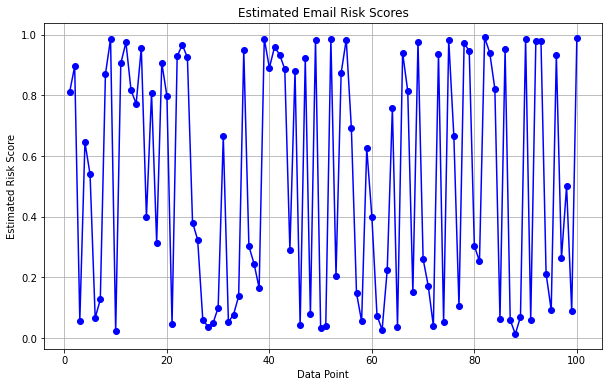

In [20]:
from keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_email_risk_with_visualization(model_file, input_data):
    """
    This function opens a machine learning model, uses it to estimate the risk of
    each provided data point being high-risk, and visualizes these estimates.
    
    Arguments:
    - model_file: The file location of the machine learning model.
    - input_data: Data for the model to evaluate, formatted as an array.
    
    Outcome:
    - A visualization of each data point's estimated risk score.
    """
    # Opening the specified machine learning model
    trained_model = load_model(model_file)
    
    # Using the model to estimate email risk for the provided data
    estimated_risk = trained_model.predict(input_data).flatten()
    
    # Organizing the risk estimates into a table
    risk_table = pd.DataFrame({
        'Data Point': np.arange(1, len(estimated_risk) + 1),
        'Estimated Risk Score': estimated_risk
    })
    
    # Visualizing the risk scores
    plt.figure(figsize=(10, 6))
    plt.plot(risk_table['Data Point'].values, risk_table['Estimated Risk Score'].values, marker='o', linestyle='-', color='blue')
    plt.title('Estimated Email Risk Scores')
    plt.xlabel('Data Point')
    plt.ylabel('Estimated Risk Score')
    plt.grid(True)
    plt.show()
    
    # Sharing the organized table
    return risk_table

# Example usage:
# Assuming `simulated_data` is already defined and matches the model's input format
email_risk_table_with_viz = evaluate_email_risk_with_visualization('rnn_model.h5', simulated_data)
# Note: You would replace 'rnn_model.h5' with the actual path to your RNN model file,
# and ensure `simulated_data` is prepared correctly for your model.
